<h1>An Autoencoder-Based Deep Learning Method 
for Genotype Imputation 
 <span class="tocSkip"></span></h1>

# Introduction

This is the python code for AE model for genotype imputation on human HLA data from 1000 Genomes Project.


# Load library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape, Flatten, Lambda, Input, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout, Dense, Reshape
#from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import L1

from tensorflow.keras.layers import Conv1DTranspose

%matplotlib inline   
from matplotlib import pyplot as plt

import scipy.stats as stats


In [2]:
import time

#timestr = time.strftime("%Y%m%d-%H%M%S")
timestr = time.strftime("%Y/%m/%d-%H:%M:%S")
print('timestr', timestr)

timestr 2022/09/27-18:28:02


# Dataset

In [24]:
# set data path for user

import os

data_path = '/ihome/msong/Multi_omics_imputation_08302021/data'
print('data_path:', data_path)


data_path: /ihome/msong/Multi_omics_imputation_08302021/data


# Load HLA data

In [3]:
# 07/23/2022: HLA new metrics (CR, PCC, IQS, HEN, SEN)
# load HLA data
import csv


file_name = 'HLA_filterd_012_v2.csv'
input_name = os.path.join(data_path, file_name)

#print(input_name)


feature_size = 27208
sample_num = 2504 + 1


# # small test case
# feature_size = 128
# sample_num = 200 + 1





# header/columns labels
f = open(input_name)
reader = csv.reader(f)
cols_label = next(reader)
#cols_label = cols_label[9:sample_num]
cols_label = cols_label[1:sample_num]
print('snp cols_label:', cols_label[:10])

lines2skip = 0
rows_label = pd.read_csv(input_name, skiprows=(lines2skip+0), usecols=range(0,1))
print('snp rows_label:', rows_label[:8])

snp_cols_label = cols_label
snp_rows_label = rows_label[0:feature_size]


#snp = pd.read_csv(input_name, skiprows=lines2skip, usecols = range(9,sample_num), nrows=feature_size)
snp = pd.read_csv(input_name, skiprows=lines2skip, usecols = range(1,sample_num), nrows=feature_size)

print("snp shape:", snp.shape)
print("snp :", snp.values[0:8, 0:20])

# add 1 to all genotype: SCDA
snp_new = snp + 1
print("snp_new new :", snp_new.values[0:8, 0:20])

# transpose
snp_new_t = snp_new.transpose()
print("snp_new_t shape:", snp_new_t.shape)




snp cols_label: ['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102', 'HG00103', 'HG00105', 'HG00106', 'HG00107']
snp rows_label:         POS
0  28690555
1  28690607
2  28690649
3  28690670
4  28690688
5  28690891
6  28690948
7  28691031
snp shape: (27208, 2504)
snp : [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
snp_new new : [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 3 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
snp_new_t shap

In [4]:
import random

run_times = 1
#run_times = 3

#print(random.randrange(20, 50, 3))
random_seed = [0 for i in range(run_times)]

for i in range(run_times):
    random_seed[i] = random.randrange(28213, 28213*4, 12)

    
print('random_seed:', random_seed)    

random_seed: [86509]


# Evaluation metrics

In [5]:


def beagle_r2(data_imp):

    # 5.30.2022, Calculate Beagle R2 (without ground truth)
    print('Beagle R2.')
    
    # predict
    # SCDA
    #predict_onehot = SCDA.predict(test_X_missing[:, :, :])
    predict_onehot = data_imp
    
    print('predict_onehot:', predict_onehot.shape)
    #print('predict_onehot:', predict_onehot[0:1, :, :])
    
    #predict_onehot_t = predict_onehot.transpose()
    predict_onehot_t = predict_onehot.transpose(1, 0, 2)
    print('predict_onehot_t:', predict_onehot_t.shape) 
#     print('predict_onehot_t:', predict_onehot_t[0:1, 0:5, :])
    
    snp_cnt = predict_onehot_t.shape[0]
    sample_cnt = predict_onehot_t.shape[1]
    print('snp_cnt:', snp_cnt) 
    print('sample_cnt:', sample_cnt) 
    
    
    # ui = yi(1) + 2yi(2)
    u = [[0 for x in range(sample_cnt)] for y in range(snp_cnt)] 
    
    # wi = yi(1) + 4yi(2)
    w = [[0 for x in range(sample_cnt)] for y in range(snp_cnt)]
    
    # z: highest prob
    z = [[0 for x in range(sample_cnt)] for y in range(snp_cnt)]
    
    R2 = [0 for x in range(snp_cnt)]
    
    for i in range(snp_cnt):
        for j in range(sample_cnt):
            u[i][j] = predict_onehot_t[i][j][2] + 2*predict_onehot_t[i][j][3]
            
            w[i][j] = predict_onehot_t[i][j][2] + 4*predict_onehot_t[i][j][3]
            
            #z[i][j] = predict_onehot_t[i][j].max()
            z[i][j] = np.argmax(predict_onehot_t[i][j]) - 1
            #print('u, w, z:', i, j, u[i][j], w[i][j], z[i][j])

    
    
    # check constant values in z
    mask_constant = [0 for x in range(snp_cnt)]
    
    for i in range(snp_cnt):
        # result = len(listOfStrings) > 0 and all(elem == listOfStrings[0] for elem in listOfStrings)
        
        z_value = z[i]
        #mask_constant[i] = len(listOfStrings) > 0 and all(elem == listOfStrings[0] for elem in listOfStrings)
        flag = len(z_value) > 0 and all(elem == z_value[0] for elem in z_value)
        if (flag == True):
            mask_constant[i] = 1
        
    #print('mask_constant:', mask_constant)
    
    mask_constant_cnt = sum(mask_constant)
    print('mask_constant_cnt:', mask_constant_cnt)
    
    for i in range(snp_cnt):
        s_zu = 0
        s_z = 0
        s_u = 0
        s_w = 0
        s_zz = 0
        
        if(mask_constant[i] == 1):
            R2[i] = 1
#             print('Constant R2[i]:', i, R2[i])
            
        else:

            for j in range(sample_cnt):
                s_zu = s_zu + z[i][j]*u[i][j]
                s_z = s_z + z[i][j]
                s_u = s_u + u[i][j]

                s_w = s_w + w[i][j]
                s_zz = s_zz + z[i][j]*z[i][j]

#             print('sum:', i, s_zu, s_z, s_u, s_w, s_zz)

            #R2[i] = ((s_zu-(1/sample_cnt)*s_u*s_z)**2)/((s_w-(1/sample_cnt)*(s_u**2))*(s_zz-(1/sample_cnt)*(s_z**2)))  
            tmp1 = (s_zu-(1/sample_cnt)*s_u*s_z)**2
            tmp2 = s_w-(1/sample_cnt)*(s_u**2)
            tmp3 = s_zz-(1/sample_cnt)*(s_z**2)
#             print('R2 tmp1_2_3:', i, tmp1, tmp2, tmp3)

            R2[i] = tmp1/(tmp2*tmp3)

#             print('R2[i]:', i, R2[i])
    
#     print('R2:', R2)
    
    
    
    # check R2>=0.8
    r2_th = 0.8
    mask_valid = [0 for x in range(snp_cnt)]
    
    for i in range(snp_cnt):
        if (R2[i] >= r2_th):
            mask_valid[i] = 1
            
    mask_valid_cnt = sum(mask_valid)
    print('R2 mask_valid_cnt:', mask_valid_cnt)
    
    mask_valid_perc = mask_valid_cnt/snp_cnt
    print('R2 mask_valid_perc:', mask_valid_perc)

    return R2, mask_valid_perc


# 09/19/2022, pcc for dosage, from reviewer 1.

def pcc(data_imp, data_obs):
    # SCDA   
    sample_cnt = data_imp.shape[0]
    snp_cnt = data_imp.shape[1]
    
    
    
    dose_obs = [[0 for x in range(snp_cnt)] for y in range(sample_cnt)] 
    dose_imp = [[0 for x in range(snp_cnt)] for y in range(sample_cnt)]
 
    for i in range(sample_cnt):
        for j in range(snp_cnt):            
            dose_obs[i][j] = 1*data_obs[i,j,2] + 2*data_obs[i,j,3]
            dose_imp[i][j] = 1*data_imp[i,j,2] + 2*data_imp[i,j,3]

    y_true = dose_obs
    y_pred = dose_imp
     
    
    
    # pcc
    rows = sample_cnt
    cols = snp_cnt
    
    
    print('rows:', rows)
    print('cols:', cols)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    r = []
    p = []
    rp = []

    pcc_na_cnt = 0
    
    for i in range(cols):
        a = y_true[:, i]
        b = y_pred[:, i]

#         print('a:', i, a)
#         print('b:', i, b)

        # check constant vector
        flag1 = len(a) > 0 and all(elem == a[0] for elem in a)
        flag2 = len(b) > 0 and all(elem == b[0] for elem in b)
        
        if (flag1 == True) or (flag2 == True):
            r.append(np.nan)
            p.append(np.nan)
            rp.append((np.nan, np.nan))    
    
            pcc_na_cnt = pcc_na_cnt + 1
            
        else:
            pcc = stats.pearsonr(a, b)
            r.append(pcc[0])
            p.append(pcc[1])
            rp.append(pcc)

    print('pcc_na_cnt:', pcc_na_cnt)
    print('pcc_non-na_cnt:', (snp_cnt-pcc_na_cnt))


    cols = len(rp)
    #print('pcc non-na len:', cols)

    rp_valid = []
    for i in range(cols):
        rp_r = rp[i][0]
        rp_p = rp[i][1]

        #if(rp_r>0.1) and (rp_p<0.05):
        if(rp_r>0.8) and (rp_p<0.05):
            
            #rp_valid.append(rp[i])
            rp_valid.append([i, rp[i]])

    #print('pcc rp_valid:', rp_valid)
    print('pcc rp_valid:', len(rp_valid))
    
    #pcc_valid_ratio = len(rp_valid)/cols
    pcc_valid_ratio = len(rp_valid)/(snp_cnt-pcc_na_cnt)
    
   
    print('pcc rp_valid ratio:', pcc_valid_ratio)   
    
    
    return r, pcc_valid_ratio



def hellinger_score(data_imp, data_obs):
    #predict_onehot = SCDA.predict(test_X_missing[:, :, :])
    predict_onehot = data_imp
    
    print('predict_onehot:', predict_onehot.shape)
    #print('predict_onehot:', predict_onehot[0:1, :, :])
    
    # predict_onehot_t: rows (snps); cols (samples)
    #predict_onehot_t = predict_onehot.transpose()
    predict_onehot_t = predict_onehot.transpose(1, 0, 2)
    print('predict_onehot_t:', predict_onehot_t.shape) 
#     print('predict_onehot_t:', predict_onehot_t[0:1, 0:5, :])
    
    snp_cnt = predict_onehot_t.shape[0]
    sample_cnt = predict_onehot_t.shape[1]
    print('snp_cnt:', snp_cnt) 
    print('sample_cnt:', sample_cnt) 
    
    test_X_onehot = data_obs
    test_X_onehot_t = test_X_onehot.transpose(1, 0, 2)
    print('test_X_onehot_t:', test_X_onehot_t.shape)     

    
    hellinger_score = [[0 for x in range(sample_cnt)] for y in range(snp_cnt)] 
 
    for i in range(snp_cnt):
        for j in range(sample_cnt):
            
            tmp = 0
            f1 = test_X_onehot_t[i][j]
            f2 = predict_onehot_t[i][j]
            
            for k in range(3):
                tmp = tmp + np.sqrt(f1[k+1]*f2[k+1])

            hellinger_score[i][j] = 1-np.sqrt(1-tmp)


    hellinger_score_mean = [0 for x in range(snp_cnt)]
    hellinger_score_std = [0 for x in range(snp_cnt)]
    
    hellinger_score_min = [0 for x in range(snp_cnt)]
    hellinger_score_max = [0 for x in range(snp_cnt)]
    
    hellinger_score_median = [0 for x in range(snp_cnt)]
    hellinger_score_quantile = [0 for x in range(snp_cnt)]
    
    for i in range(snp_cnt):
        hellinger_score_mean[i] = np.mean(hellinger_score[i])
        hellinger_score_std[i] = np.std(hellinger_score[i])

        hellinger_score_min[i] = np.amin(hellinger_score[i])
        hellinger_score_max[i] = np.amax(hellinger_score[i])

        hellinger_score_median[i] = np.median(hellinger_score[i])
        hellinger_score_quantile[i] = np.quantile(hellinger_score[i], 0.5)

    
    print('hellinger_score_mean mean:', np.mean(hellinger_score_mean))
    print('hellinger_score_min mean:', np.mean(hellinger_score_min))
    
    
    # check hellinger score > 0.45
    hs_th = 0.45
    
    #hellinger_score_mean
    mask_valid = [0 for x in range(snp_cnt)]
    
    for i in range(snp_cnt):
        if (hellinger_score_mean[i] >= hs_th):
            mask_valid[i] = 1
            
    mask_valid_cnt = sum(mask_valid)
    print('hellinger_score_mean mask_valid_cnt:', mask_valid_cnt)
    
    mask_valid_perc_mean = mask_valid_cnt/snp_cnt
    print('hellinger_score_mean mask_valid_perc:', mask_valid_perc_mean)
    
    #hellinger_score_min
    mask_valid = [0 for x in range(snp_cnt)]
    
    for i in range(snp_cnt):
        if (hellinger_score_min[i] >= hs_th):
            mask_valid[i] = 1
            
    mask_valid_cnt = sum(mask_valid)
    print('hellinger_score_min mask_valid_cnt:', mask_valid_cnt)
    
    mask_valid_perc_min = mask_valid_cnt/snp_cnt
    print('hellinger_score_min mask_valid_perc:', mask_valid_perc_min)

    return hellinger_score_mean, hellinger_score_min, mask_valid_perc_mean, mask_valid_perc_min



def sen_score(data_imp, data_obs):
    
    #predict_onehot = SCDA.predict(test_X_missing[:, :, :])
    predict_onehot = data_imp 
    
    print('predict_onehot:', predict_onehot.shape)
    #print('predict_onehot:', predict_onehot[0:1, :, :])
    
    # predict_onehot_t: rows (snps); cols (samples)
    #predict_onehot_t = predict_onehot.transpose()
    predict_onehot_t = predict_onehot.transpose(1, 0, 2)
    print('predict_onehot_t:', predict_onehot_t.shape) 
#     print('predict_onehot_t:', predict_onehot_t[0:1, 0:5, :])
    
    snp_cnt = predict_onehot_t.shape[0]
    sample_cnt = predict_onehot_t.shape[1]
    print('snp_cnt:', snp_cnt) 
    print('sample_cnt:', sample_cnt) 
    
    
    test_X_onehot = data_obs
    test_X_onehot_t = test_X_onehot.transpose(1, 0, 2)
    print('test_X_onehot_t:', test_X_onehot_t.shape)     

    
    sen_score = [[0 for x in range(sample_cnt)] for y in range(snp_cnt)] 
 
    for i in range(snp_cnt):
        for j in range(sample_cnt):
            dose_obs = 1*test_X_onehot_t[i][j][2] + 2*test_X_onehot_t[i][j][3]
            dose_imp = 1*predict_onehot_t[i][j][2] + 2*predict_onehot_t[i][j][3]
            sen_score[i][j] = 1-((np.square(dose_obs-dose_imp))/4)


    
    sen_score_mean = [0 for x in range(snp_cnt)]
    sen_score_std = [0 for x in range(snp_cnt)]
    
    sen_score_min = [0 for x in range(snp_cnt)]
    sen_score_max = [0 for x in range(snp_cnt)]
    
    sen_score_median = [0 for x in range(snp_cnt)]
    sen_score_quantile = [0 for x in range(snp_cnt)]
    
    for i in range(snp_cnt):
        sen_score_mean[i] = np.mean(sen_score[i])
        sen_score_std[i] = np.std(sen_score[i])

        sen_score_min[i] = np.amin(sen_score[i])
        sen_score_max[i] = np.amax(sen_score[i])

        sen_score_median[i] = np.median(sen_score[i])
        sen_score_quantile[i] = np.quantile(sen_score[i], 0.5)

    
    print('sen_score_mean mean:', np.mean(sen_score_mean))
    print('sen_score_min mean:', np.mean(sen_score_min))

    return sen_score_mean, sen_score_min, np.mean(sen_score_mean), np.mean(sen_score_min)
    
    
def iqs_score(data_imp, data_obs):
    #predict_onehot = SCDA.predict(test_X_missing[:, :, :])
    predict_onehot = data_imp 
    
    print('predict_onehot:', predict_onehot.shape)

    # predict_onehot_t: rows (snps); cols (samples)
    predict_onehot_t = predict_onehot.transpose(1, 0, 2)
    
    data_imp = np.argmax(predict_onehot_t, axis=2)
   
    data_imp_012 = data_imp - 1
    
    
    print('data_imp_012:', data_imp_012.shape) 
    
    snp_cnt = data_imp_012.shape[0]
    sample_cnt = data_imp_012.shape[1]
    print('snp_cnt:', snp_cnt) 
    print('sample_cnt:', sample_cnt) 

    test_X_onehot = data_obs
    test_X_onehot_t = test_X_onehot.transpose(1, 0, 2)
    print('test_X_onehot_t:', test_X_onehot_t.shape)     

    data_obs = np.argmax(test_X_onehot_t, axis=2) 
    data_obs_012 = data_obs - 1    
    
    
    iqs = [0 for x in range(snp_cnt)]    
    
    
    for i in range(snp_cnt):
        iqs_cnt = [[0 for x in range(3)] for y in range(3)]
        
        for j in range(sample_cnt):
            if(data_obs_012[i][j]==0) and (data_imp_012[i][j]==0):
                iqs_cnt[0][0] = iqs_cnt[0][0] + 1
            elif(data_obs_012[i][j]==1) and (data_imp_012[i][j]==0):
                iqs_cnt[0][1] = iqs_cnt[0][1] + 1
            elif(data_obs_012[i][j]==2) and (data_imp_012[i][j]==0):
                iqs_cnt[0][2] = iqs_cnt[0][2] + 1    

            elif(data_obs_012[i][j]==0) and (data_imp_012[i][j]==1):
                iqs_cnt[1][0] = iqs_cnt[1][0] + 1
            elif(data_obs_012[i][j]==1) and (data_imp_012[i][j]==1):
                iqs_cnt[1][1] = iqs_cnt[1][1] + 1    
            elif(data_obs_012[i][j]==2) and (data_imp_012[i][j]==1):
                iqs_cnt[1][2] = iqs_cnt[1][2] + 1
                
            elif(data_obs_012[i][j]==0) and (data_imp_012[i][j]==2):
                iqs_cnt[2][0] = iqs_cnt[2][0] + 1
            elif(data_obs_012[i][j]==1) and (data_imp_012[i][j]==2):
                iqs_cnt[2][1] = iqs_cnt[2][1] + 1    
            elif(data_obs_012[i][j]==2) and (data_imp_012[i][j]==2):
                iqs_cnt[2][2] = iqs_cnt[2][2] + 1
                
        po = (iqs_cnt[0][0] + iqs_cnt[1][1]+ iqs_cnt[2][2])/sample_cnt
        
        pc_rows_0 = iqs_cnt[0][0] + iqs_cnt[0][1]+ iqs_cnt[0][2]
        pc_rows_1 = iqs_cnt[1][0] + iqs_cnt[1][1]+ iqs_cnt[1][2]
        pc_rows_2 = iqs_cnt[2][0] + iqs_cnt[2][1]+ iqs_cnt[2][2]        
    
        pc_cols_0 = iqs_cnt[0][0] + iqs_cnt[1][0]+ iqs_cnt[2][0]
        pc_cols_1 = iqs_cnt[0][1] + iqs_cnt[1][1]+ iqs_cnt[2][1]
        pc_cols_2 = iqs_cnt[0][2] + iqs_cnt[1][2]+ iqs_cnt[2][2]
    
        pc = (pc_rows_0*pc_cols_0 + pc_rows_1*pc_cols_1 + pc_rows_2*pc_cols_2)/(sample_cnt**2)
    

        if(pc == 1):
            iqs[i] = 1
        else:
            iqs[i] = (po - pc)/(1 - pc)
    
    
    #print('iqs:', iqs)
    print('iqs mean:', np.mean(iqs))
    return iqs, np.mean(iqs)
     

# Build AE model

In [13]:
# AE model parameters


# missing ratio
#missing_perc = 0.1
#missing_perc = 0.0
missing_perc = 0.2


# epochs
#epochs = 10   
epochs = 60 
#epochs = 100   # chr20 LOS 5K


# training batch size
#batch_size = 32   # u19, 4984 samples
bs = 32


# optimizer learning rate
lr = 1e-3



# l1 regulalization
kr = 1e-4
k_initial = 'glorot_uniform'


kernel_len = 5

#feature_size = feature_size

# channel = inChannel
channel = 4

num_latent = 128
p_size = 2
ndf_num = 32


#dr_rate = drop_prec
dr_rate = 0.2  # avoid overfitting for missing ratio of 0.7







In [17]:
# AE model in one cell



# # V1: verify our own ae model with yeast genotype data

# # 2.2.8 build variatial autoencoder for snp with subclassing function. 

class SNP_ENCODER(Model):    
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, n_latent=num_latent, dr=dr_rate):    
        super(SNP_ENCODER, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate

        # object, can be saved in tf mode
        self.stride=1
        self.kl = 5

        
    def build(self, inputs): 
        #encoder
        # dense layer 1
        self.c1 = Conv1D(filters=self.ndf, kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, 
                      kernel_initializer=k_initial, kernel_regularizer=L1(kr), 
                      input_shape=(self.feature_size, self.channel))
        self.p1 = MaxPooling1D(pool_size=p_size)
        self.drop1 = Dropout(rate=self.dr)
        
        # dense layer 2
        self.c2 = Conv1D(filters=(2*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, kernel_initializer=k_initial, 
                      kernel_regularizer=L1(kr))
        self.p2 = MaxPooling1D(pool_size=p_size)
        self.drop2 = Dropout(rate=self.dr)
        
        # dense layer 3
        self.c3 = Conv1D(filters=(4*self.ndf), kernel_size=self.kl, strides=1, padding="same", 
                      activation='relu', use_bias=True, kernel_initializer=k_initial, 
                      kernel_regularizer=L1(kr))
        self.p3 = MaxPooling1D(pool_size=p_size)
        self.drop3 = Dropout(rate=self.dr)

        super(SNP_ENCODER, self).build(inputs)
    
    def call(self, inputs, training=True):
        #print('SNP_ENCODER training flag: ', training)
        x = self.c1(inputs)
        x = self.p1(x)
        x = self.drop1(x, training=training)

        x = self.c2(x)
        x = self.p2(x)
        x = self.drop2(x, training=training)
        
        x = self.c3(x)
        return x

    # AFAIK: The most convenient method to print model.summary() 
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = Input(shape=(self.feature_size, self.channel))
        return Model(inputs=[x], outputs=self.call(x))
    
    
    
# SNP_DECODER(keras.Model):   
class SNP_DECODER(Model):     
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, n_latent=num_latent, dr=dr_rate):
        super(SNP_DECODER, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate
        
        # object, can be saved in tf mode
        self.stride=1
        self.kl=5
        
    def build(self, inputs):
        #decoder        
        self.c1 = Conv1D(filters=(2*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, 
                      kernel_initializer=k_initial, kernel_regularizer=L1(kr),
                      input_shape=((self.feature_size>>2), self.n_latent))
        
        
        self.s1 = UpSampling1D(size=p_size)
        self.drop1 = Dropout(rate=self.dr)
        
        # dense layer 2
        self.c2 = Conv1D(filters=(1*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, 
                      kernel_initializer=k_initial, kernel_regularizer=L1(kr))

        self.s2 = UpSampling1D(size=p_size)
        self.drop2 = Dropout(rate=self.dr)
        

        # dense layer6
        self.c3 = Conv1D(filters=self.channel, kernel_size=self.kl, strides=1, padding="same", 
                      activation='softmax', use_bias=True)
        
        super(SNP_DECODER, self).build(inputs)
        
    def call(self, inputs, training = True):
        #print('SNP_DECODER training flag: ', training)
        x = self.c1(inputs)
        x = self.s1(x)
        x = self.drop1(x, training=training)
        
        x = self.c2(x)
        x = self.s2(x)
        x = self.drop2(x, training=training)

        
        d_out = self.c3(x)
        return d_out
    
    # AFAIK: The most convenient method to print model.summary() 
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = Input(shape=(self.feature_size>>2, self.n_latent))
        
        return Model(inputs=[x], outputs=self.call(x))
    

    
#class SNP_AE(keras.Model):
class SNP_AE(Model):    
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, n_latent=num_latent, dr=dr_rate):    
        super(SNP_AE, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate      
        
        self.encoder = SNP_ENCODER(self.feature_size)
        self.decoder = SNP_DECODER(self.feature_size)
    

    def call(self, x, training=True): 
        latent = self.encoder(x, training)     
        res = self.decoder(latent, training)

        return res, latent
    
    # AFAIK: The most convenient method to print model.summary() 
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = Input(shape=(self.feature_size, self.channel))
        return Model(inputs=[x], outputs=self.call(x))
    








In [8]:
# plot snp vae encoder model

SNP_encoder = SNP_ENCODER(feature_size)
SNP_encoder.build((None, feature_size, channel))
SNP_encoder.build_graph().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 27208, 4)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 27208, 32)         672       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13604, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 13604, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13604, 64)         10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6802, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6802, 64)          0     

In [9]:
# plot snp vae decoder model

SNP_decoder = SNP_DECODER(feature_size)

SNP_decoder.build((None, feature_size>>2, num_latent))
SNP_decoder.build_graph().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6802, 128)]       0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6802, 64)          41024     
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 13604, 64)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13604, 64)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 13604, 32)         10272     
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 27208, 32)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 27208, 32)         0   

In [18]:
# plot snp vae model

SNP_ae = SNP_AE(feature_size)
SNP_ae.build((None, feature_size, channel))
SNP_ae.build_graph().summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 27208, 4)]        0         
_________________________________________________________________
snp_encoder_3 (SNP_ENCODER)  (None, 6802, 128)         52064     
_________________________________________________________________
snp_decoder_3 (SNP_DECODER)  (None, 27208, 4)          51940     
Total params: 104,004
Trainable params: 104,004
Non-trainable params: 0
_________________________________________________________________


In [19]:
# AE model sub-functions

def generate_fake_missing(x_in, missing_ratio):

        # Generates missing genotypes
        # different missing loci for each individuals
        x_fake = x_in.copy()   # with .copy() to not overwrite the original data
        
        for i in range(x_in.shape[0]):
            missing_size = int(missing_ratio * x_in.shape[1])
          
            # without repeat random numbers: set replace with false
            missing_index = np.random.choice(x_in.shape[1], size=missing_size, replace=False)
            
            # missing loci are encoded as [0, 0]
            #x_fake[i, missing_index, :] = [1, 0, 0]  # yeast
            x_fake[i, missing_index, :] = [1, 0, 0, 0]  # human

        return x_fake
        #return x_fake, x_in
    
    

def loss_function_cce(recon_x, x):
    # orders: y_true, y_pred
    cce = categorical_crossentropy(x, recon_x)

    #cce = np.double(cce)
    cce = K.cast(cce, dtype='float32')

    lamb1 = 1.0
    loss = lamb1*cce
    #print('loss:', loss)
    
    loss = tf.reduce_mean(loss)
    #print('ave loss:', loss)
    
    return loss


In [20]:
# check AE model parameters

#epochs = 100   # chr20 LOS 5K

print('feature_size:', feature_size)
print('epochs:', epochs)

#bs = 20
#bs = batch_size
#bs = 32
print('bs:', bs)

#missing_ratio = 0
#missing_ratio = 0.1
#missing_ratio = 0.2
missing_ratio = missing_perc
print('missing_ratio:', missing_ratio)

print('random_seed:', random_seed)



feature_size: 27208
epochs: 60
bs: 32
missing_ratio: 0.2
random_seed: [86509]


# Train AE model

In [21]:
# base version v2: sigle vae for snp 

# 1.3 train snp vae only
from tensorflow.keras.losses import mean_squared_error, categorical_crossentropy

from tensorflow.keras.losses import CategoricalCrossentropy

# l1 distance
from scipy.spatial.distance import cityblock


#run_times = 2



for k in range(run_times):
    print("#**********************************************************************#:")
    print("start of k_th time:", k)
    
    # set random seed for split
    print("start of k_th seed:", k, random_seed[k])
    #np.random.seed(seed=28213)
    np.random.seed(seed=random_seed[k])
    
    
    # split into training/valid and test data for HLA, U19 data, 1000G except yeast data
    # for yeast data, skip it.
    
    
    # if (data_type == 'Human')
    df_ori, test_X = train_test_split(snp_new_t, test_size=0.2)
    print("df_ori shape:", df_ori.shape)
    print("test_X shape:", test_X.shape)
    # else: skip for yeast
    
    
    
    
    # one hot encode
    df_onehot = to_categorical(df_ori)
    #df_onehot.shape
    print("df_onehot.shape:", df_onehot.shape)

    # Further split df_ori to train and valid
    train_X, valid_X = train_test_split(df_onehot, test_size=0.2)
    #train_X.shape, valid_X.shape
    print("train_X.shape:", train_X.shape)
    print("valid_X.shape:", valid_X.shape)
    
    
    # fake missing values
    train_X_fake = generate_fake_missing(train_X, missing_ratio)

    diff = np.absolute(np.array(train_X) - np.array(train_X_fake))
    print('train_X_fake diff:', np.sum(diff))


    valid_X_fake = generate_fake_missing(valid_X, missing_ratio)
    diff = np.absolute(np.array(valid_X) - np.array(valid_X_fake))
    print('valid_X_fake diff:', np.sum(diff))


    

    snp_ae = SNP_AE(feature_size)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    train_loss_metric = tf.keras.metrics.CategoricalCrossentropy()
    val_loss_metric = tf.keras.metrics.CategoricalCrossentropy()


    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()


    loss_vae = []

    loss_train = []
    loss_val = []

    acc_train = []
    acc_val = []


    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        #----shuffle train data and lablel for each epoch-----------------------------------------------------------------------------------#    
        # shuffle data and labels at the same time
        idx = train_X.shape[0]


        indices = tf.range(start=0, limit=idx, dtype=tf.int32)
        #print('indices:', indices)

        shuffled_indices = tf.random.shuffle(indices)  
      
        train_X_fake = tf.gather(train_X_fake, shuffled_indices)
        train_X = tf.gather(train_X, shuffled_indices)        
        
        snp_x = tf.data.Dataset.from_tensor_slices(train_X_fake).batch(bs, drop_remainder=True) 
        snp_y = tf.data.Dataset.from_tensor_slices(train_X).batch(bs, drop_remainder=True)

        snp_x_v = tf.data.Dataset.from_tensor_slices(valid_X_fake).batch(bs, drop_remainder=True)
        snp_y_v = tf.data.Dataset.from_tensor_slices(valid_X).batch(bs, drop_remainder=True)

        loss_batch = []

        # Iterate over the batches of the dataset.
        for step, (snp_fake_batch, snp_label_batch) in enumerate(zip(snp_x, snp_y)): 
            with tf.GradientTape() as tape:
                recon_inputs, latents= snp_ae(snp_fake_batch, training=True)
                loss = loss_function_cce(recon_inputs, snp_label_batch)


            grads = tape.gradient(loss, snp_ae.trainable_variables)
            optimizer.apply_gradients(zip(grads, snp_ae.trainable_variables))    

            loss_batch.append(loss.numpy())


            # Update training metric.
            train_acc_metric.update_state(snp_label_batch, recon_inputs)
            train_loss_metric.update_state(snp_label_batch, recon_inputs)


        # Display metrics at the end of each epoch.
        train_loss = train_loss_metric.result()
        print("Training loss over epoch: ", epoch, train_loss.numpy())

        train_acc = train_acc_metric.result()
        print("Training acc over epoch: ", epoch, train_acc.numpy())


        loss_train.append(train_loss.numpy())
        acc_train.append(train_acc.numpy())


        # Reset training metrics at the end of each epoch
        train_loss_metric.reset_states()
        train_acc_metric.reset_states()


        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in zip(snp_x_v, snp_y_v):   

            val_recons, latents = snp_ae(x_batch_val, training=False)
            # Update val metrics
            val_loss_metric.update_state(y_batch_val, val_recons)
            val_acc_metric.update_state(y_batch_val, val_recons)

        val_loss = val_loss_metric.result()
        val_acc = val_acc_metric.result()

        loss_val.append(val_loss.numpy())
        acc_val.append(val_acc.numpy())

        val_loss_metric.reset_states()
        val_acc_metric.reset_states()
        #print("Validation acc: %.4f" % (float(val_acc),))
        print("Validation loss: ", epoch, val_loss.numpy())
        print("Validation acc: ", epoch, val_acc.numpy())


        #print('epoch %s: batch loss = %s' % (epoch, loss_batch))
        loss_epoch = np.mean(loss_batch)    
        print('epoch %s: loss = %s' % (epoch, loss_epoch))    

        loss_vae.append(loss_epoch)    

    print('loss_vae:', loss_vae) 

    print('loss train:', loss_train)     
    print('loss val:', loss_val)     

    print('acc train:', acc_train)     
    print('acc val:', acc_val) 

    #write out loss and accuracy into excels
    loss2 = loss_train
    val_loss2 = loss_val

    acc2 = acc_train
    val_acc2 = acc_val
    
    #ae_loss = [loss1, val_loss1, acc1, val_acc1]
    ae_loss = [loss2, val_loss2, acc2, val_acc2]


    file_name = 'ae_hla_loss_acc_v'+str(k)+'_missing_ratio_'+str(missing_perc)+'.xlsx'
    file_path_out = os.path.join(data_path, file_name)

    cols_label = [0 for i in range(epochs)]

    for i in range(epochs):
        cols_label[i] = 'epoch_'+str(i+1)

    print('cols_label:', cols_label)    


    rows_label = ['AE_loss', 'AE_val_loss', 'AE_acc', 'AE_val_acc']
    print('rows_label:', rows_label)    

    df = pd.DataFrame(data = np.array(ae_loss), index = rows_label, columns = cols_label)
    df.to_excel(file_path_out, na_rep='NA', header=True, index=True, float_format="%.6f")  

    # load test data 
#     #1.0 test yeast data
#     input_name = '/ihome/msong/u19/data/yeast_genotype_test.txt'
#     df_ori = pd.read_csv(input_name, sep='\t', index_col=0)
#     print('test yeast:', df_ori.shape)


    #2.0 test human data: HLA, U19, 1000G
    df_ori = test_X
    #df_ori.shape 
    print('test human:', df_ori.shape)
    
    
    
    # one hot encode
    test_X_onehot = to_categorical(df_ori)
    #test_X_onehot.shape
    print('test_X_onehot:', test_X_onehot.shape)

    #test_X_missing = test_X.copy()
    test_X_missing = test_X_onehot[:, 0:feature_size, :].copy()

    #test_X_missing.shape
    print('test_X_missing:', test_X_missing.shape)
    
    
    # test evaluation
    avg_accuracy = []
    avg_rmse = []
    avg_l1 = []
    avg_cos_thelta = []

    
    avg_miss = []
        
    log_freq = 50
    
    
    for i in range(test_X_missing.shape[0]):
        if (i % log_freq ==0):
            print('test sample:', i)
        
        # Generates missing genotypes
        missing_size = int(missing_perc * test_X_missing.shape[1])
        
        
        # without repeat random numbers: set replace with false
        missing_index = np.random.choice(test_X_missing.shape[1], size=missing_size, replace=False)

        
        if(missing_perc != 0):
            #test_X_missing[i, missing_index, :] = [1, 0, 0]  # yeast
            test_X_missing[i, missing_index, :] = [1, 0, 0, 0]  # human

            

        # AE

        predict_onehot, latent_test = snp_ae(test_X_missing[i:i + 1, :, :], training=False)
        predict_onehot = predict_onehot.numpy()


        # only care the missing position
        if(missing_perc == 0):
            predict_missing_onehot = predict_onehot[0:1, :, :]
        else:
            predict_missing_onehot = predict_onehot[0:1, missing_index, :]


        # predict label
        predict_missing = np.argmax(predict_missing_onehot, axis=2)

        # real label

        if(missing_perc == 0):
            label_missing_onehot = test_X_onehot[i:i + 1, :, :]
        else:
            label_missing_onehot = test_X_onehot[i:i + 1, missing_index, :]



        label_missing = np.argmax(label_missing_onehot, axis=2)

        
        # accuracy
        correct_prediction = np.equal(predict_missing, label_missing)
        accuracy = np.mean(correct_prediction)
        
        if (i % log_freq ==0):
            print('{}/{}, sample ID: {}, accuracy: {:.4f}'.format(
                i, test_X_missing.shape[0], df_ori.index[i], accuracy))

        avg_accuracy.append(accuracy)


    ###############################################################

    
    # write out test of 1kg
    predict_onehot, latent_test = snp_ae(test_X_missing[:, :, :], training=False)
    
    print('predict_onehot:', predict_onehot.shape)

    # save imputed LOS output

    file_name = 'AE_hla_imputed_v'+str(k)+'_missing_ratio_'+str(missing_perc)+'.csv'
    file_path_out = os.path.join(data_path, file_name)
    
    data = np.argmax(predict_onehot, axis=2)
    print('predict_data:', data.shape)
    
    data = data - 1
    
    # transpose
    df_data = data.transpose()
    print("df_data shape:", df_data.shape)
    
    df = pd.DataFrame(data = np.array(df_data), columns = df_ori.index)
    df.insert(loc=0, column='snp_pos', value=snp_rows_label.values)
    df.to_csv(file_path_out, na_rep='NA', header=True, index=False)      
    
    
     ###############################################################
        
    # calculate metrics: 6/6/2022
    
    #data_imp = SCDA.predict(test_X_missing[:, :, :])
    data_imp_ae, latent_test = snp_ae(test_X_missing[:, :, :], training=False)
    data_imp = np.array(data_imp_ae)
    
    data_obs = test_X_onehot

    
    # 5.30.2022, Calculate Beagle R2 (without ground truth)
    print('Beagle R2.')
        
    R2_a, R2_valid_perc_a = beagle_r2(data_imp)
    print('R2_valid_perc:', R2_valid_perc_a)
    
    print('AE avt R2:', np.mean(R2_a))
    
    
    ###############################################################   
    
    # 6/2/2022
    # PCC: squared pearson correlation coefficient
    print('PCC: squared pearson correlation coefficient') 
    
    r_a, pcc_valid_perc_a = pcc(data_imp, data_obs)
    print('pcc_valid_perc:', pcc_valid_perc_a)
    
    #print('AE avt pcc:', np.mean(r_a))
    print('AE avt pcc:', np.nanmean(r_a))
    
    
    ###############################################################   
  
    # 6/4/2022
    # Hellinger score
    # for each snp, calculate the mean (sd, minimum, maximum, median, quartiles) 
    # of hellinger score across samples
    
    print('Hellinger score')
    
    
    hellinger_score_mean_a, hellinger_score_min_a, hellinger_valid_perc_mean_a, hellinger_valid_perc_min_a \
    = hellinger_score(data_imp, data_obs)
    
    print('hellinger_valid_perc:', hellinger_valid_perc_mean_a, hellinger_valid_perc_min_a)
    
        
        
        
    ###############################################################   
    # 6/4/2022
    # SEN score: Scaled Euclidian Norm Score
    # for each snp, calculate the mean (sd, minimum, maximum, median, quartiles) 
    # of SEN score across samples
    
    print('SEN  score')
    
    
    sen_score_mean_a, sen_score_min_a, sen_score_mean_mean_a, sen_score_min_mean_a \
    = sen_score(data_imp, data_obs)
    
    print('sen_mean:', sen_score_mean_mean_a, sen_score_min_mean_a)
    

    ###############################################################   
    # 6/4/2022
    # IQS: imputation quality score
    # for each snp, calculate IQS across samples 
    print('IQS')
        
    iqs_a, iqs_mean_a = iqs_score(data_imp, data_obs)
    
    print('iqs_mean:', iqs_mean_a)
    
    
        
    print('avg_miss:', avg_miss)
    print('avg_miss ratio:', np.mean(avg_miss))
    
    ae_metrics = [avg_accuracy]


    file_name = 'ae_hla_metrics_acc_v'+str(k)+'_missing_ratio_'+str(missing_perc)+'.csv'
    file_path_out = os.path.join(data_path, file_name)


    cols_label = [0 for i in range(test_X_missing.shape[0])]

    for i in range(test_X_missing.shape[0]):
        cols_label[i] = 'sample_'+ str(df_ori.index[i])

    rows_label = ['accuracy']
    print('rows_label:', rows_label)    

    df = pd.DataFrame(data = np.array(ae_metrics), index = rows_label, columns = cols_label)
    df.to_csv(file_path_out, na_rep='NA', header=True, index=True, float_format="%.6f") 
    
    
    # 7/14/2022 write out r2, pcc, hen, sen, iqs
    scda_metrics = [R2_a, r_a, hellinger_score_mean_a, hellinger_score_min_a, 
                    sen_score_mean_a, sen_score_min_a, iqs_a]


    file_name = 'ae_hla_metrics_new_v'+str(k)+'_missing_ratio_'+str(missing_perc)+'.csv'
    file_path_out = os.path.join(data_path, file_name)

    
    cols_label = snp_rows_label.values.ravel() 

    rows_label = ['r2', 'pcc', 'hen', 'hen_min', 'sen', 'sen_min', 'iqs']
    
    print('rows_label:', rows_label)    

    
    df = pd.DataFrame(data = np.array(scda_metrics), columns = cols_label)
    df.insert(loc=0, column='metrics', value=rows_label)
    
    
    df.to_csv(file_path_out, na_rep='NA', header=True, index=False, float_format="%.6f")   


    
    # write out average metrics over samples
    print('avt acc:', np.mean(avg_accuracy))    

    scda_metrics_avg = [np.mean(avg_accuracy), np.mean(R2_a), np.nanmean(r_a), 
                        np.mean(hellinger_score_mean_a), np.mean(hellinger_score_min_a),
                        np.mean(sen_score_mean_a), np.mean(sen_score_min_a), iqs_mean_a]


    file_name = 'ae_hla_metrics_avg_v'+str(k)+'_missing_ratio_'+str(missing_perc)+'.xlsx'
    file_path_out = os.path.join(data_path, file_name)
        
    
    cols_label = ['avg_metrics']
    print('test cols_label:', cols_label)    

    rows_label = ['avg_accuracy','avg_r2','avg_pcc','avg_hel','avg_hel_min','avg_sen',
                 'avg_sen_min','avg_iqs']
    
    print('rows_label:', rows_label)    

    df = pd.DataFrame(data = np.array(scda_metrics_avg), index = rows_label, columns = cols_label)
    df.to_excel(file_path_out, na_rep='NA', header=True, index=True, float_format="%.6f")  

      
    
# add timestamp
import time

timestr1 = time.strftime("%Y/%m/%d")
timestr2 = time.strftime("%H:%M:%S")
timestr = [timestr1, timestr2]
print('timestr', timestr)
 
file_name = 'ae_hla_log_v'+str(k)+'_missing_ratio_'+str(missing_perc)+'.csv'
file_path_out = os.path.join(data_path, file_name)
    
    
rows_label = ['day', 'time']
cols_label = ['value']
  
df = pd.DataFrame(data = np.array(timestr), columns = cols_label)
df.insert(loc=0, column='Time_log', value=rows_label)

    
df.to_csv(file_path_out, na_rep='NA', header=True, index=False)     
        
    

#**********************************************************************#:
start of k_th time: 0
start of k_th seed: 0 86509
df_ori shape: (2003, 27208)
test_X shape: (501, 27208)
df_onehot.shape: (2003, 27208, 4)
train_X.shape: (1602, 27208, 4)
valid_X.shape: (401, 27208, 4)
train_X_fake diff: 17432964.0
valid_X_fake diff: 4363682.0
Start of epoch 0
Training loss over epoch:  0 0.3443746
Training acc over epoch:  0 0.9331229
Validation loss:  0 0.2409186
Validation acc:  0 0.9432055
epoch 0: loss = 0.34437463
Start of epoch 1
Training loss over epoch:  1 0.22665806
Training acc over epoch:  1 0.94235814
Validation loss:  1 0.19393162
Validation acc:  1 0.9432071
epoch 1: loss = 0.22665802
Start of epoch 2
Training loss over epoch:  2 0.18122774
Training acc over epoch:  2 0.9424873
Validation loss:  2 0.15142624
Validation acc:  2 0.95011884
epoch 2: loss = 0.18122777
Start of epoch 3
Training loss over epoch:  3 0.15303712
Training acc over epoch:  3 0.9461842
Validation loss:  3 0.12

Training loss over epoch:  42 0.06209218
Training acc over epoch:  42 0.98624045
Validation loss:  42 0.050694216
Validation acc:  42 0.98849595
epoch 42: loss = 0.06209219
Start of epoch 43
Training loss over epoch:  43 0.06184948
Training acc over epoch:  43 0.98629403
Validation loss:  43 0.050592013
Validation acc:  43 0.9885055
epoch 43: loss = 0.061849475
Start of epoch 44
Training loss over epoch:  44 0.06164125
Training acc over epoch:  44 0.98632073
Validation loss:  44 0.050347082
Validation acc:  44 0.98855233
epoch 44: loss = 0.06164126
Start of epoch 45
Training loss over epoch:  45 0.061521284
Training acc over epoch:  45 0.98634374
Validation loss:  45 0.050153557
Validation acc:  45 0.98857665
epoch 45: loss = 0.061521288
Start of epoch 46
Training loss over epoch:  46 0.061321273
Training acc over epoch:  46 0.9863855
Validation loss:  46 0.050017543
Validation acc:  46 0.9885837
epoch 46: loss = 0.06132128
Start of epoch 47
Training loss over epoch:  47 0.061227288
Tr

test sample: 250
250/501, sample ID: HG02332, accuracy: 0.9353
test sample: 300
300/501, sample ID: HG02699, accuracy: 0.9410
test sample: 350
350/501, sample ID: HG02611, accuracy: 0.9568
test sample: 400
400/501, sample ID: NA19740, accuracy: 0.9403
test sample: 450
450/501, sample ID: HG04153, accuracy: 0.9412
test sample: 500
500/501, sample ID: HG01686, accuracy: 0.9351
predict_onehot: (501, 27208, 4)
predict_data: (501, 27208)
df_data shape: (27208, 501)
Beagle R2.
Beagle R2.
predict_onehot: (501, 27208, 4)
predict_onehot_t: (27208, 501, 4)
snp_cnt: 27208
sample_cnt: 501
mask_constant_cnt: 12795
R2 mask_valid_cnt: 16021
R2 mask_valid_perc: 0.5888341664216407
R2_valid_perc: 0.5888341664216407
AE avt R2: 0.7026603973490323
PCC: squared pearson correlation coefficient
rows: 501
cols: 27208
pcc_na_cnt: 11869
pcc_non-na_cnt: 15339
pcc rp_valid: 11475
pcc rp_valid ratio: 0.7480930960297282
pcc_valid_perc: 0.7480930960297282
AE avt pcc: 0.8071992238877398
Hellinger score
predict_onehot:

/ihome/msong/anaconda3/envs/keras_torch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/ihome/msong/anaconda3/envs/keras_torch/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


avt acc: 0.9442306344854859
test cols_label: ['avg_metrics']
rows_label: ['avg_accuracy', 'avg_r2', 'avg_pcc', 'avg_hel', 'avg_hel_min', 'avg_sen', 'avg_sen_min', 'avg_iqs']
timestr ['2022/09/27', '21:43:33']


#**************************************************************************#
plot i_th fig: 1
loss1 start: [0.344375, 0.226658, 0.181228, 0.153037, 0.132845]
loss1 end: []
val_loss1 start: [0.240919, 0.193932, 0.151426, 0.129595, 0.107857]
val_loss1 end: []


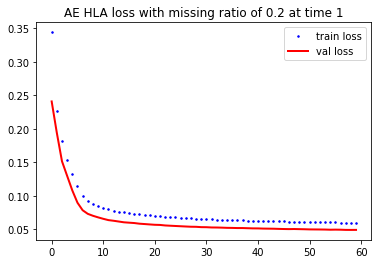

acc1 start: [0.933123, 0.942358, 0.942487, 0.946184, 0.955211]
acc1 end: []
val_acc1 start: [0.943205, 0.943207, 0.950119, 0.964434, 0.973222]
val_acc1 end: []


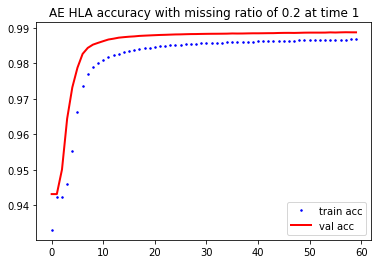

In [22]:
#v2: test AE mdoel metrics


# plot loss curve on validation data
import pandas as pd
import xlrd

from matplotlib import pyplot as plt


for i in range(run_times):
    print('#**************************************************************************#')
    print('plot i_th fig:', (i+1))
    
    # load loss from excels

    file_name = 'ae_hla_loss_acc_v'+str(i)+'_missing_ratio_'+str(missing_perc)+'.xlsx'
    data_file = os.path.join(data_path, file_name)

    
    
    df = pd.read_excel(data_file)


    # plot loss
    
    loss1 = df.iloc[0,1:].values.tolist()
    val_loss1 = df.iloc[1,1:].values.tolist()
    


    print('loss1 start:', loss1[0:5])
    print('loss1 end:', loss1[95:100])
    
    print('val_loss1 start:', val_loss1[0:5])
    print('val_loss1 end:', val_loss1[95:100])

    
    plt.figure()
    plt.plot(range(len(loss1)), loss1, 'bo', linewidth=2, markersize=1.5, label='train loss')
    plt.plot(range(len(val_loss1)), val_loss1, 'r', linewidth=2, markersize=1.5, label='val loss')

    #plt.title('AE U19 loss with missing ratio of '+str(missing_perc)+' at time '+str(i+1))
    plt.title('AE HLA loss with missing ratio of '+str(missing_perc)+' at time '+str(i+1))


    plt.legend()
    plt.show()



    # plot accuracy


    acc1 = df.iloc[2,1:].values.tolist()
    val_acc1 = df.iloc[3,1:].values.tolist()
    
    print('acc1 start:', acc1[0:5])
    print('acc1 end:', acc1[95:100])
    
    print('val_acc1 start:', val_acc1[0:5])
    print('val_acc1 end:', val_acc1[95:100])    
    
    plt.figure()
    plt.plot(range(len(acc1)), acc1, 'bo', linewidth=2, markersize=1.5, label='train acc')
    plt.plot(range(len(val_acc1)), val_acc1, 'r', linewidth=2, markersize=1.5, label='val acc')

    #plt.title('AE U19 accuracy with missing ratio of '+str(missing_perc)+' at time '+str(i+1))
    plt.title('AE HLA accuracy with missing ratio of '+str(missing_perc)+' at time '+str(i+1))


    plt.legend()
    plt.show()


In [23]:
# calculate average metric and std

import pandas as pd
import xlrd
import statistics

from matplotlib import pyplot as plt



avg_acc = []
avg_r2 = []
avg_pcc = []
avg_hen = []
avg_hen_min = []
avg_sen = []
avg_sen_min = []
avg_iqs = []

for i in range(run_times):
    print('#**************************************************************************#')
    print('ae with time:', (i+1))
    

    file_name = 'ae_hla_metrics_avg_v'+str(i)+'_missing_ratio_'+str(missing_perc)+'.xlsx'
    data_file = os.path.join(data_path, file_name)

    

    #df = pd.read_excel(data_file, sheet_name='Sheet1')
    df = pd.read_excel(data_file)

    d = df.iloc[0,1:2].values.tolist()[0]
    #d = df.iloc[0,1:2].values
    print('avg_acc:', d)
    avg_acc.append(d)
    
    d = df.iloc[1,1:2].values.tolist()[0]
    print('avg_r2:', d)
    avg_r2.append(d)    

    d = df.iloc[2,1:2].values.tolist()[0]
    print('avg_pcc:', d)
    avg_pcc.append(d)  
    
    d = df.iloc[3,1:2].values.tolist()[0]
    print('avg_hen:', d)
    avg_hen.append(d)  
    
    d = df.iloc[4,1:2].values.tolist()[0]
    print('avg_hen_min:', d)
    avg_hen_min.append(d)  
    
    d = df.iloc[5,1:2].values.tolist()[0]
    print('avg_sen:', d)
    avg_sen.append(d)      
    
    d = df.iloc[6,1:2].values.tolist()[0]
    print('avg_sen_min:', d)
    avg_sen_min.append(d)     
    
    d = df.iloc[7,1:2].values.tolist()[0]
    print('avg_iqs:', d)
    avg_iqs.append(d)      
    

    
# metrics
print('#**************************************************************************#')
print('avt_acc:', avg_acc)    

print('#**************************************************************************#') 


acc_mean = np.mean(avg_acc)

r2_mean = np.mean(avg_r2)
pcc_mean = np.mean(avg_pcc)
hen_mean = np.mean(avg_hen)
hen_min_mean = np.mean(avg_hen_min)
sen_mean = np.mean(avg_sen)
sen_min_mean = np.mean(avg_sen_min)
iqs_mean = np.mean(avg_iqs)


acc_std = np.std(avg_acc)
r2_std = np.std(avg_r2)
pcc_std = np.std(avg_pcc)
hen_std = np.std(avg_hen)
hen_min_std = np.std(avg_hen_min)
sen_std = np.std(avg_sen)
sen_min_std = np.std(avg_sen_min)
iqs_std = np.std(avg_iqs)


print('avt_acc:', acc_mean, acc_std)    

    
print('#**************************************************************************#') 
    
# write out
avg_acc.append(acc_mean)
avg_acc.append(acc_std)
#avg_acc.append(acc_p)

avg_r2.append(r2_mean)
avg_r2.append(r2_std)

avg_pcc.append(pcc_mean)
avg_pcc.append(pcc_std)


avg_hen.append(hen_mean)
avg_hen.append(hen_std)

avg_hen_min.append(hen_min_mean)
avg_hen_min.append(hen_min_std)

avg_sen.append(sen_mean)
avg_sen.append(sen_std)

avg_sen_min.append(sen_min_mean)
avg_sen_min.append(sen_min_std)

avg_iqs.append(iqs_mean)
avg_iqs.append(iqs_std)



print('avt_acc:', avg_acc)    

metrics = [avg_acc, avg_r2, avg_pcc, avg_hen, avg_hen_min, avg_sen, avg_sen_min, avg_iqs]

print('metrics:', metrics)        
 

file_name = 'ae_hla_metrics_times_'+str(run_times)+'_missing_ratio_'+str(missing_perc)+'_v1.1.xlsx'
file_path_out = os.path.join(data_path, file_name)


cols_label = [0 for i in range(run_times+2)]

for i in range(run_times):
    cols_label[i] = 'time_'+str(i+1)

cols_label[run_times] = 'mean' 
cols_label[run_times+1] = 'std' 

print('cols_label:', cols_label)    



rows_label = ['ae_avg_acc', 'ae_avg_r2', 'ae_avg_pcc', 
              'ae_avg_hen', 'ae_avg_hen_min', 'ae_avg_sen',
             'ae_avg_sen_min', 'ae_avg_iqs']

print('rows_label:', rows_label)    

df = pd.DataFrame(data = np.array(metrics), index = rows_label, columns = cols_label)
df.to_excel(file_path_out, na_rep='NA', header=True, index=True, float_format="%.6f")  

        
    
    
    
    
    
    

#**************************************************************************#
ae with time: 1
avg_acc: 0.944231
avg_r2: 0.70266
avg_pcc: 0.807199
avg_hen: 0.948322
avg_hen_min: 0.515345
avg_sen: 0.995078
avg_sen_min: 0.830217
avg_iqs: 0.902145
#**************************************************************************#
avt_acc: [0.944231]
#**************************************************************************#
avt_acc: 0.944231 0.0
#**************************************************************************#
avt_acc: [0.944231, 0.944231, 0.0]
metrics: [[0.944231, 0.944231, 0.0], [0.70266, 0.70266, 0.0], [0.807199, 0.807199, 0.0], [0.948322, 0.948322, 0.0], [0.515345, 0.515345, 0.0], [0.995078, 0.995078, 0.0], [0.830217, 0.830217, 0.0], [0.902145, 0.902145, 0.0]]
cols_label: ['time_1', 'mean', 'std']
rows_label: ['ae_avg_acc', 'ae_avg_r2', 'ae_avg_pcc', 'ae_avg_hen', 'ae_avg_hen_min', 'ae_avg_sen', 'ae_avg_sen_min', 'ae_avg_iqs']
